<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/20_GPax_MultiTaskGP_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 100
    NUM_SAMPLES = 100
    SMOKE = True
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000
    SMOKE = False

# "Theory-informed" data reconstruction and Bayesian optimization with multi-task GP

*Prepared by Maxim Ziatdinov (July 2023). Last updated in October 2023*

---
The purpose of this notebook is to demonstrate a concept of theory-guided Bayesian optimization when theoretical simulations are available beforehand and are used to guide the measurements through a multi-task Gaussian process. This can be used as an alternative solution to a structured Gaussian process in situations where a mean function is too costly to compute at each step or it is expressed through some complex program that is not fully differentiable.

---

In the field of Gaussian Processes (GPs), the Linear Model of Coregionalization (LMC) provides an effective way to capture correlations across multiple outputs. This model can be particularly useful in situations where you have an abundance of "cheap" simulations performed over a dense grid in a parameter space and a small number of "expensive" experimental measurements in that space. In such scenarios, the goal is to leverage the simulations to assist in data reconstruction or to guide active learning in automated experiments.

In the LMC-based GP, the covariance between the $i$-th output of the $n$-th data point, $x_n$, and the $j$-th output of the $m$-th data point, $x_m$, can be formulated as follows:

\begin{align*}
K[Y_i(x_n), Y_j(x_m)] = \sum_{q=1}^{Q} B_{ij}^{(q)} k_q(x_n, x_m)
\end{align*}

In the above equation, $k_q(x_n, x_m)$ denotes the covariance function for the $q$-th latent process, evaluated between the $n$-th and $m$-th data points. The term $B_{ij}^{(q)}$ corresponds to the element at the $i$-th row and $j$-th column of the coregionalization matrix, $B^{(q)}$, for the $q$-th latent process. This matrix establishes the correlation structure among the various outputs and encodes their interdependencies. Each component of $B^{(q)}$ quantifies the correlation between two tasks as influenced by the $q$-th latent process.

To ensure the symmetric and positive semi-definiteness of $B^{(q)}$, it is parameterized as

\begin{align*}
B^{(q)} = W^{(q)} (W^{(q)})^T + \text{diag}(v^{(q)})
\end{align*}

In this formulation, $W^{(q)}$ is a low-rank $D \times R$ matrix, with $D$ representing the number of tasks, and $R$ being the rank. $\text{diag}(v^{(q)})$ is a diagonal matrix encapsulating specific variances for each output. Both the $W$ and $v$ matrices, along with the traditional data kernel hyperparameters and task-specific noise levels, are learned directly from the data.


## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [ ]:
!pip install gpax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 14.2 MB/s eta 0:00:00


Import needed packages:

In [ ]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

Enable some pretty plotting.

In [ ]:
import matplotlib as mpl

In [ ]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## Theory-informed data reconstruction

Let's create toy datasets. The idea is that we have a cheap theoretical simulation that we can perform over the entire parameter space and costly experiments that we can measure only in some parts of that parameter space. The theory and experiment do not match 100%. We want to use multi-fidelity/task GP to learn the correlation between the theoretical simulations and available experimental observations and use this information to aid predictions in the unmeasured parts of the parameter space.

*Please note that our data is synthetic and our "simulations" and "experiment" are not actual simulations and actual measurements. However, you can susbtitute them with your actual data and run the same code.*

In [ ]:
func = lambda x: 2 * np.sin(x/10) + 0.5 * np.sin(x/2) + 0.1 * x

def y1_func(x, noise=0):
    # Assume signal strength is some complex function of frequency x
    return func(x) + np.random.normal(0, noise, x.shape)

def y2_func(x, noise=0):
    return 1.5 * func(x) + np.sin(x/15) - 5 + np.random.normal(0, noise, x.shape)

np.random.seed(1) # for reproducibility

# Fidelity 1 - "theoretical model"
X1 = np.linspace(0, 100, 100)
y1 = y1_func(X1)

# Fidelity 2 - "experimental measurements"
X2 = np.concatenate([np.linspace(0, 25, 20), np.linspace(75, 100, 20)])  # only have data for some frequencies
y2 = y2_func(X2, noise=0.3)

# Ground truth for Fidelity 2
X_full_range = np.linspace(0, 100, 200)
y2_true = y2_func(X_full_range)


# Add fidelity indices
X = np.vstack(
    (np.column_stack((X1, np.zeros_like(X1))),  # add indices associated with the fidelity
     np.column_stack((X2, np.ones_like(X2))))   # add indices associated with the fidelity
)

# We will pass target values to GP as a single array
y = np.concatenate([y1, y2]).squeeze()

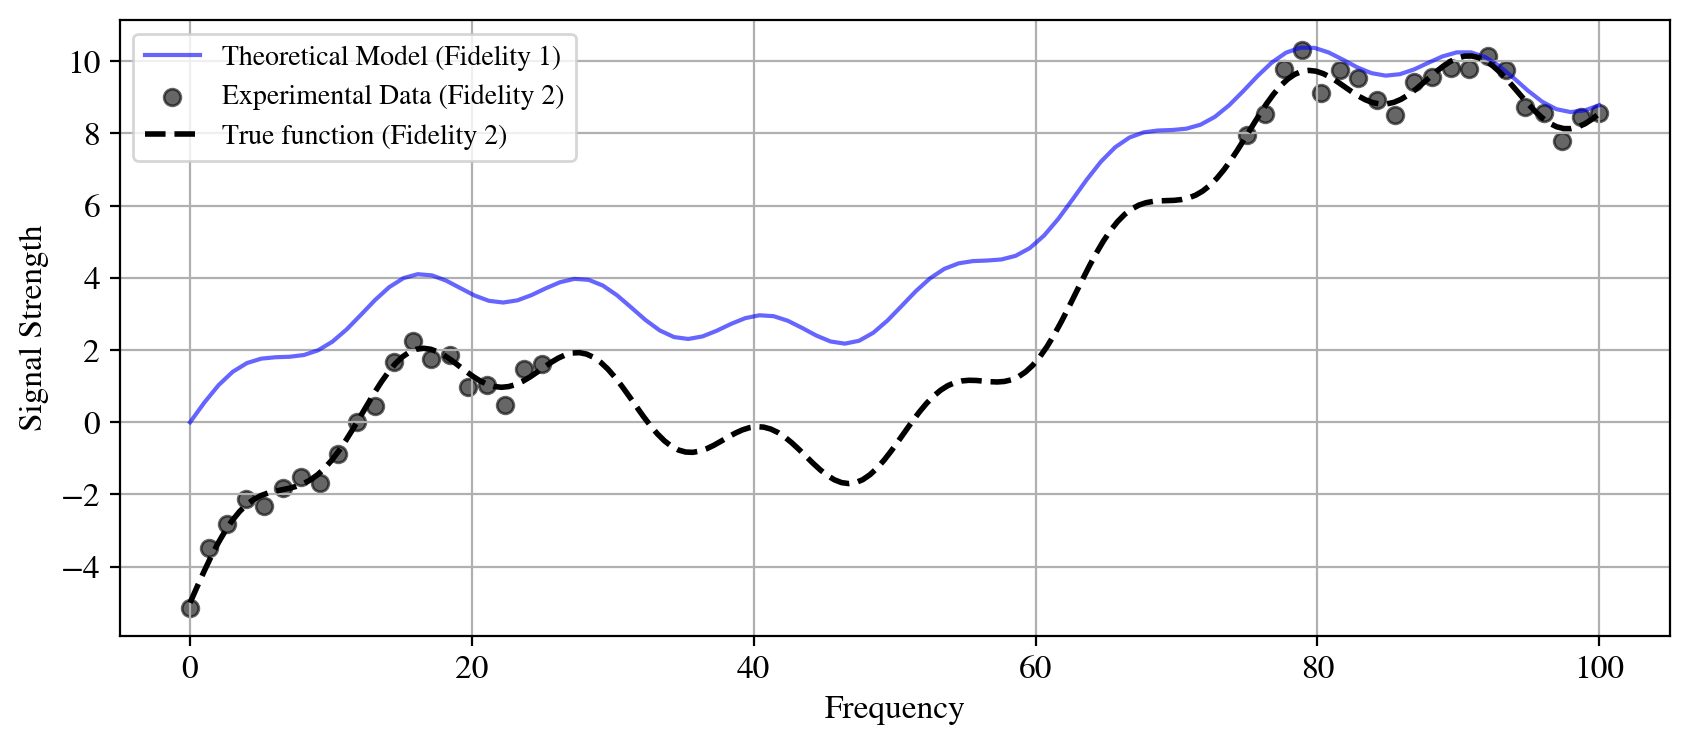

In [ ]:
# Plot the data
plt.figure(figsize=(10, 4))
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.plot(X_full_range, y2_true, 'k--', label='True function (Fidelity 2)', linewidth=2)
plt.xlabel('Frequency')
plt.ylabel('Signal Strength')
plt.legend()
plt.grid(True)
plt.show()

First, let's run a regular GP for the experimental data alone:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

model = gpax.ExactGP(1, kernel='Matern')
model.fit(key1, X2, y2, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

sample: 100%|██████████| 4000/4000 [00:18<00:00, 213.01it/s, 3 steps of size 6.79e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]     10.35      1.75     10.19      7.44     12.83   1204.47      1.00
    k_scale     18.78      7.94     17.20      7.52     28.83   1082.35      1.00
      noise      0.16      0.06      0.14      0.07      0.24   1123.58      1.00



Make a prediciton with the trained model:

In [ ]:
# Make a prediction with the trained model
y_mean, y_sampled = model.predict(key2, X_full_range, noiseless=True)

Plot results:

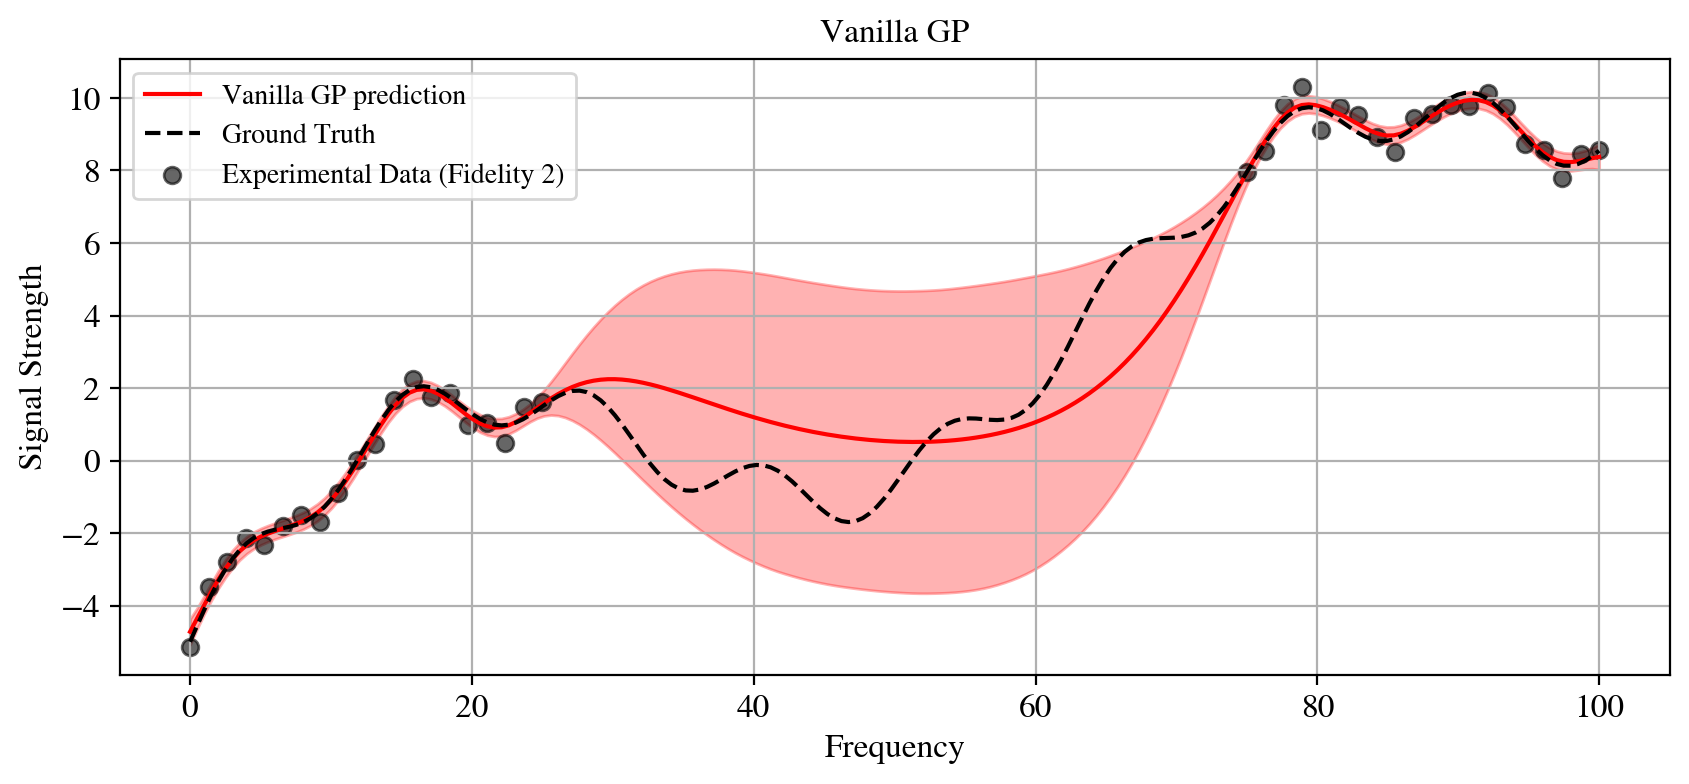

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(X_full_range, y_mean, c='red', label="Vanilla GP prediction")
plt.fill_between(X_full_range,
                y_mean - y_sampled.squeeze().std(0),
                y_mean + y_sampled.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency')
plt.ylabel('Signal Strength')
plt.title("Vanilla GP")
plt.show()

Now let's train a multi-task/fidelity GP model. Start with a single latent function:

In [ ]:
key1, key2 = gpax.utils.get_keys(1)

model = gpax.MultiTaskGP(
    input_dim=1, data_kernel='Matern',  # standard GP parameters
    shared_input_space=False,  # different fidelities have differnet number of observations
    num_latents=2,  rank=2,  # number of latent functions Q and rank of matrix W
)

model.fit(
    key1,
    X,
    y,
    num_warmup=500 if not SMOKE else NUM_WARMUP // 10,
    num_samples=500 if not SMOKE else NUM_SAMPLES // 10
)

sample: 100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s, 63 steps of size 5.73e-02. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]     -0.17      2.32     -0.26     -3.89      3.52    185.64      1.00
     W[0,0,1]     -0.05      2.37     -0.03     -3.74      3.44    159.47      1.00
     W[0,1,0]     -0.20      4.08     -0.51     -6.14      6.47    177.28      1.00
     W[0,1,1]     -0.13      4.12     -0.05     -7.01      5.65    166.45      1.00
     W[1,0,0]     -0.01      2.26     -0.04     -3.62      3.50    147.78      1.02
     W[1,0,1]     -0.02      2.20      0.05     -3.71      3.35    172.28      1.00
     W[1,1,0]      0.09      4.01     -0.00     -6.74      5.62    185.78      1.01
     W[1,1,1]      0.01      3.83     -0.08     -6.23      5.74    145.62      1.00
k_length[0,0]     30.03     21.98     17.98     12.07     64.66     46.30      1.00
k_length[1,0]     32.06     22.20     22.20     11.74     62.37     42.33      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

Make prediction (for the second task/input only) and plot results:

In [ ]:
# Create a set of inputs for the task/fidelity 2
X_test2 = np.column_stack((X_full_range, np.ones_like(X_full_range)))

# Make a prediction with the trained model
y_mean2, y_sampled2 = model.predict(key2, X_test2, noiseless=True)

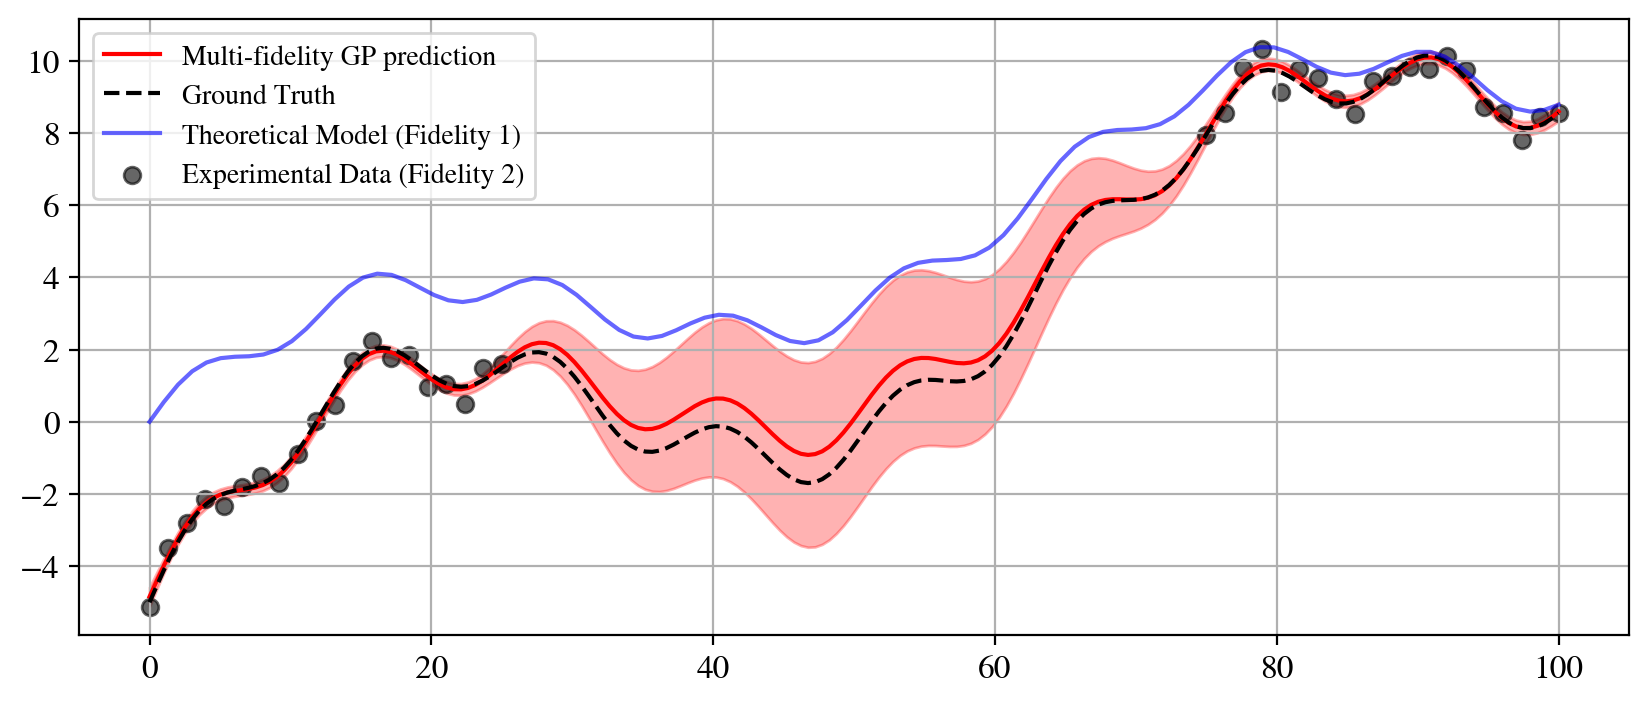

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(X_full_range, y_mean2, c='red',label="Multi-fidelity GP prediction")
plt.fill_between(X_full_range,
                y_mean2 - y_sampled2.squeeze().std(0),
                y_mean2 + y_sampled2.squeeze().std(0),
                alpha=0.3, color='red')
plt.plot(X_full_range, y2_true, 'k--', label='Ground Truth')
plt.plot(X1, y1, 'b-', label='Theoretical Model (Fidelity 1)', alpha=0.6)
plt.scatter(X2, y2, c='k', label='Experimental Data (Fidelity 2)', alpha=0.6)
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Theory-informed Bayesian optimization

Here demonstrate a theory-guided BO when theoretical simulations are available beforehand and are used to guide the measurements through a multi-task/fidelity GP. This can be used as an alternative solution to structured GP in situations where a mean function is too costly to compute at each step or it is expressed through some complex program that is not fully differentiable.

In [ ]:
# we'll need these modules for setting up custom priors
import numpyro.distributions as dist
import jax.numpy as jnp

In [ ]:
seed = 1 # for reproducibility

Let's prepare datasets. We are going to use a slightly modified Forrester function. The idea is that we have theoretical simulations that approximately describe the true function and we also have sparse experimental observations. We want to find the true minimum from as few additional measurements as possible while using theory as a guide.

*Please note that our data is synthetic and our "simulations" and "experiment" are not actual simulations and actual measurements. However, you can susbtitute them with your actual data and run the same code.*

In [ ]:
# Define data geberation functions
func = lambda x: (6*x - 2)**2 * np.sin(12*x - 4)

def y1_func(x, noise=0):
    return func(x) + np.random.normal(0, noise, x.shape)

def y2_func(x, noise=0):
    return func(x + 0.05) + 5 * (x - 0.2) + np.random.normal(0, noise, x.shape)

# Generate points in a 1D parameter space
X_full_range = np.linspace(-0.2, 1, 100)

# Generate data
np.random.seed(seed)  # for reproducibility

obs_noise = 0.2  # observational noise

# Fidelity 1 - "theoretical model"
y1 = y1_func(X_full_range)

# Fidelity 2 - "experimental measurement." Data is available only for some points
X2_idx = [5, 30]
X2 = X_full_range[X2_idx]
y2 = y2_func(X2, noise=obs_noise)

# Ground truth for Fidelity 2
y2_true = y2_func(X_full_range)

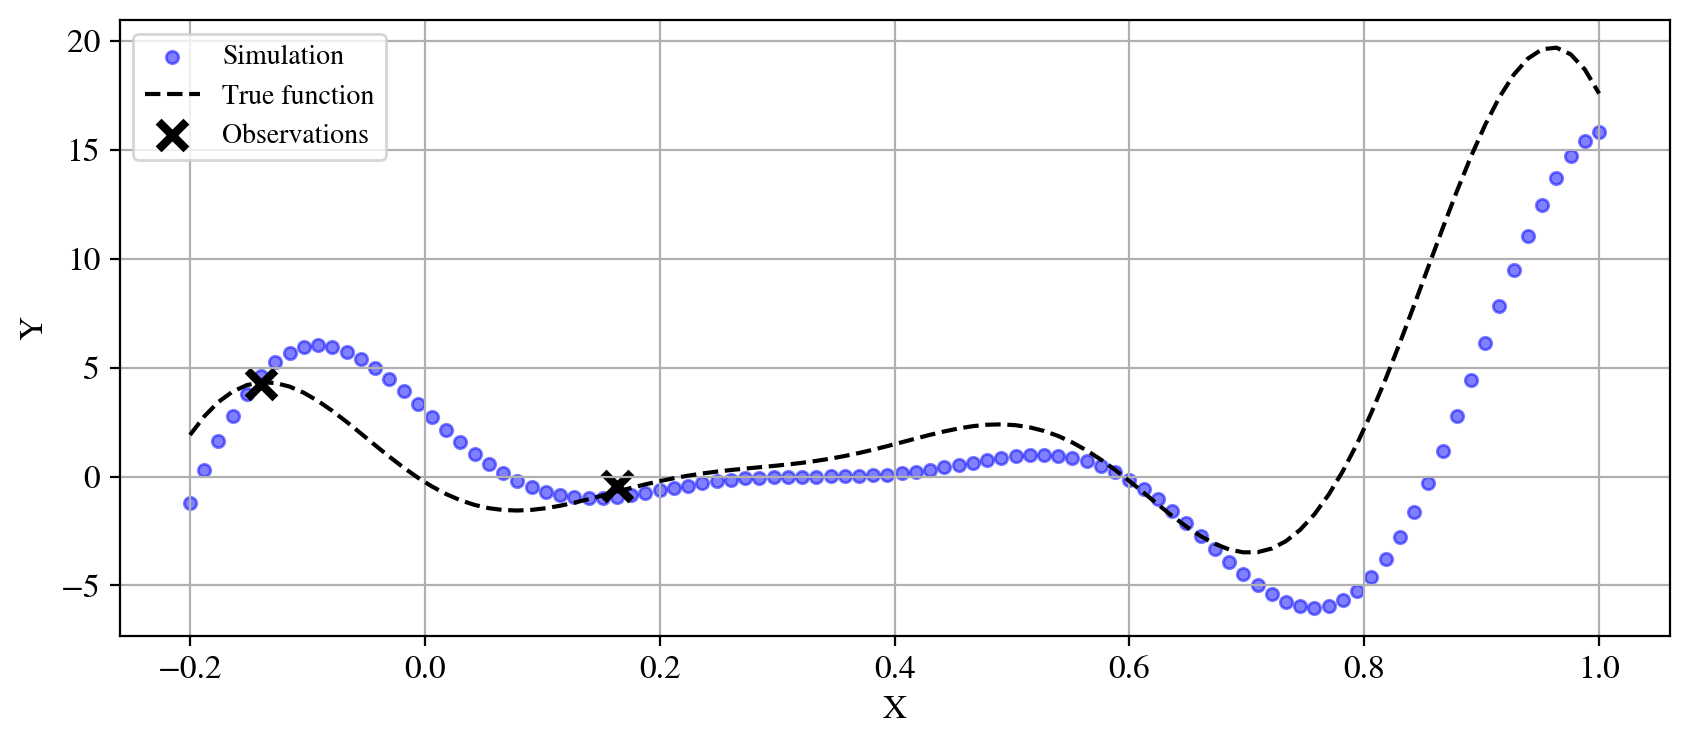

In [ ]:
# Visualize the data
plt.figure(figsize=(10, 4))
# Plot the true y1 function
plt.scatter(X_full_range, y1, c='b', alpha=0.5, s=20, label='Simulation')
# Plot the true y2 function
plt.plot(X_full_range, y2_true, 'k--', label='True function')
# Plot the observed y2 data
plt.scatter(X2, y2, c='k', s=100, marker='x', lw=3, label='Observations')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

Define a utility function for performing both vanilla GP-BO and multi-task GP-BO steps:

In [ ]:
def step(gp_model, X_measured, y_measured, X_unmeasured):

    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()

    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(
        rng_key1,
        X_measured,
        y_measured,
        num_warmup=500 if not SMOKE else NUM_WARMUP // 10,
        num_samples=500 if not SMOKE else NUM_SAMPLES // 10,
    )

    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True)

    # Compute acquisition function
    obj = gpax.acquisition.UCB(
        rng_key2,
        gp_model,
        X_unmeasured,
        beta=4,
        maximize=False,
        noiseless=True
    )

    return obj, (y_pred, y_sampled)

First, let's run a regular GP that uses only experimental observations:

In [ ]:
# Initial points
X_measured = X2.copy()
y_measured = y2.copy()

# The unmeasured points
X_unmeasured = np.delete(X_full_range, X2_idx)

num_seed_points = len(X_measured)

We are going to define custom prior distributions for the GP kernel lengthscale and the model noise. Please note that this step is not mandatory—you're free to leave them undefined (set to None). However, implementing this can significantly improve convergence. The custom prior distribution over the lengthscale takes into account that our entire X-range is confined between 0 and 1. Moreover, based on our knowledge of the approximate noise level in our observations we can accordingly assign a custom noise prior

In [ ]:
# Prior distribution over the kernel lengthscale
lenghtscale_prior = dist.Gamma(2, 5)

# Prior distribution over the model noise
noise_prior = dist.HalfNormal(0.5)

Run the standard GP-BO loop:


Step 1/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 148.58it/s, 7 steps of size 4.14e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.21      0.13      0.19      0.01      0.37    220.89      1.00
    k_scale      4.68      3.34      3.84      0.78      8.59    245.13      1.00
      noise      0.50      0.34      0.43      0.00      1.01    310.12      1.00



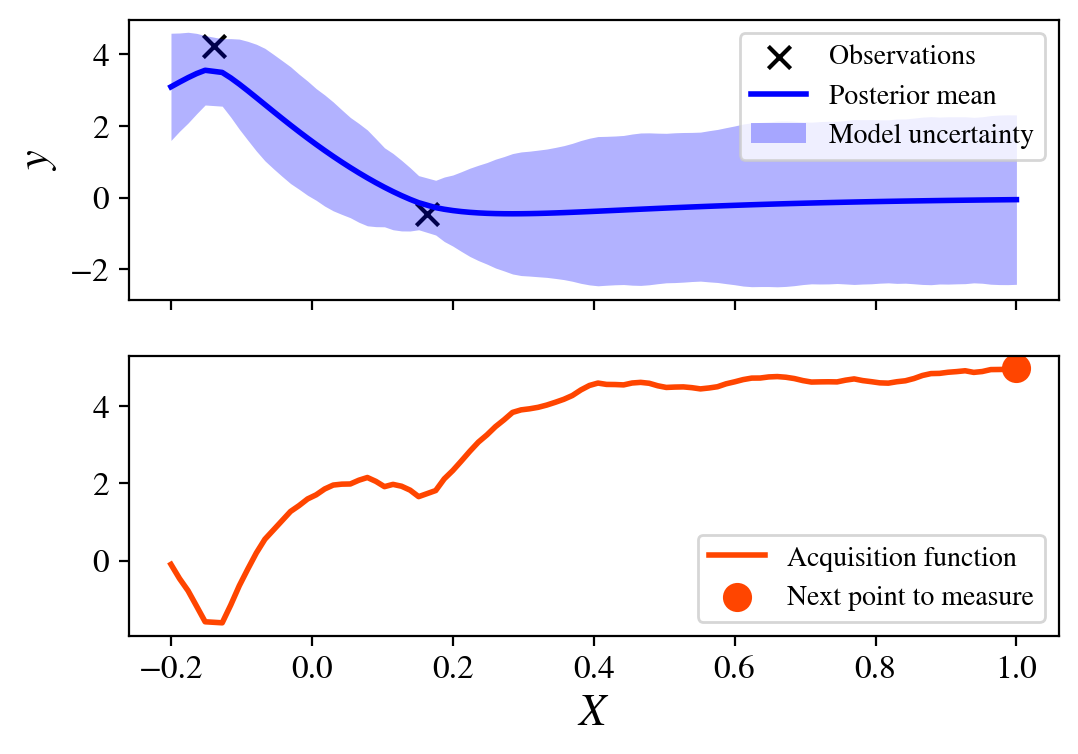


Step 2/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 157.92it/s, 7 steps of size 4.24e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.25      0.14      0.24      0.01      0.44    184.81      1.00
    k_scale     39.61     16.98     37.10     17.12     62.97    302.40      1.00
      noise      0.40      0.30      0.35      0.00      0.84    273.30      1.00



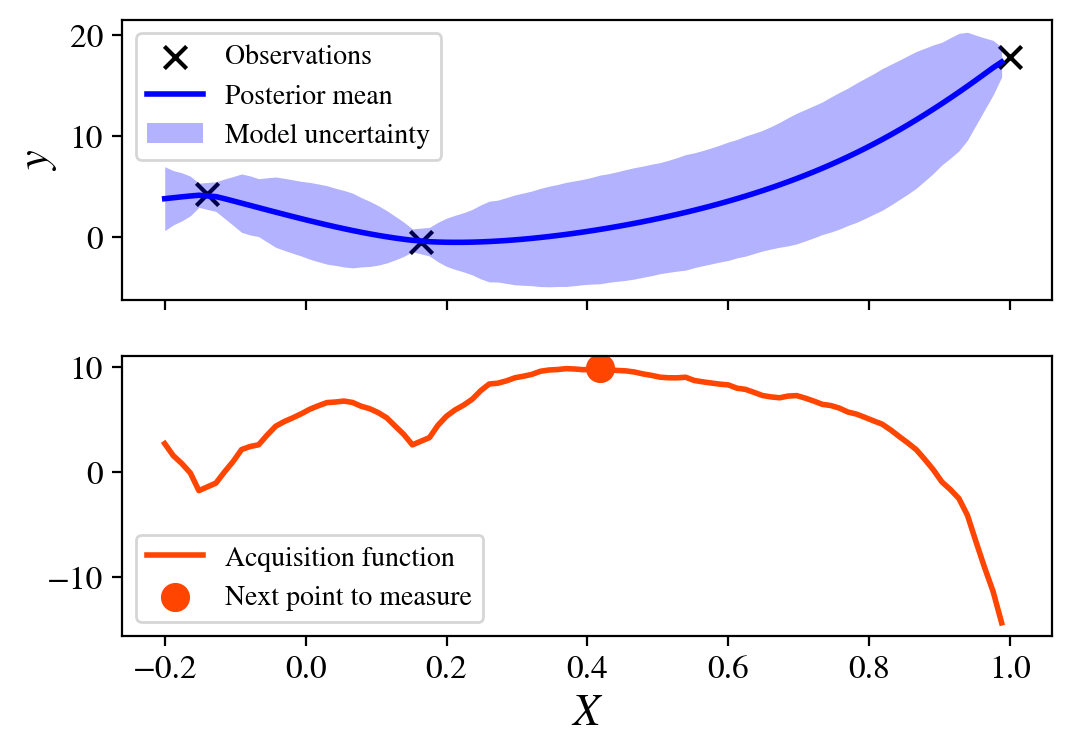


Step 3/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 158.04it/s, 7 steps of size 4.81e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.29      0.15      0.28      0.03      0.49    181.30      1.00
    k_scale     36.68     15.53     33.10     15.16     57.08    264.77      1.00
      noise      0.40      0.30      0.33      0.00      0.83    268.25      1.00



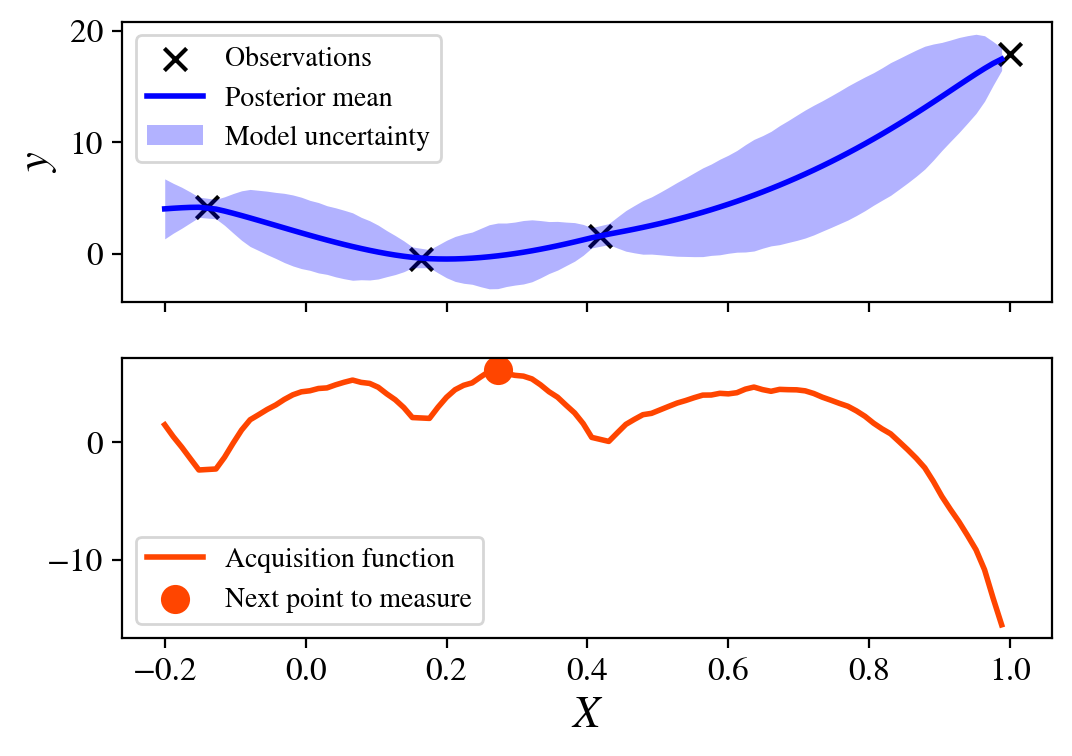


Step 4/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 164.47it/s, 7 steps of size 5.08e-01. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.36      0.15      0.36      0.09      0.57    184.62      1.00
    k_scale     37.16     16.94     33.47     15.61     60.98    244.94      1.00
      noise      0.40      0.29      0.33      0.00      0.81    253.71      1.00



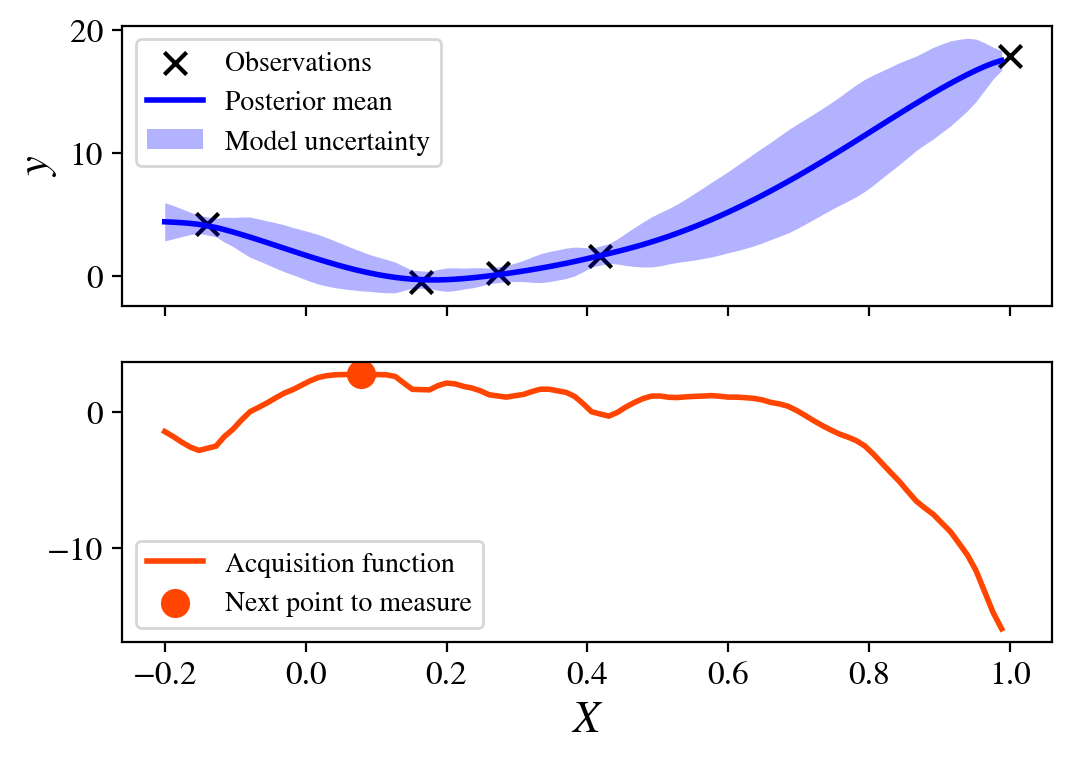


Step 5/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 156.30it/s, 7 steps of size 4.40e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.28      0.12      0.27      0.06      0.46    110.43      1.00
    k_scale     36.85     15.72     33.72     15.53     58.12    260.98      1.00
      noise      0.44      0.29      0.38      0.00      0.84    306.22      1.00



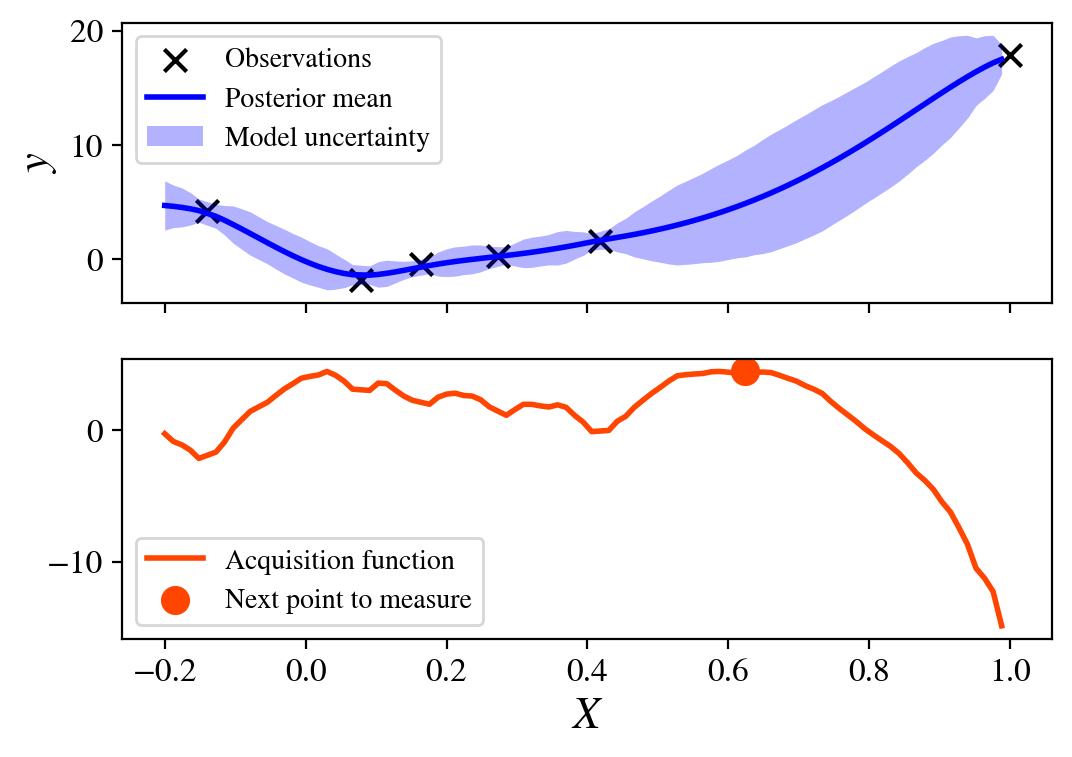


Step 6/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 150.04it/s, 7 steps of size 3.86e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.19      0.08      0.19      0.05      0.32    138.12      1.00
    k_scale     34.65     15.27     31.77     15.41     57.66    158.75      1.00
      noise      0.43      0.33      0.35      0.02      0.88    269.87      1.02



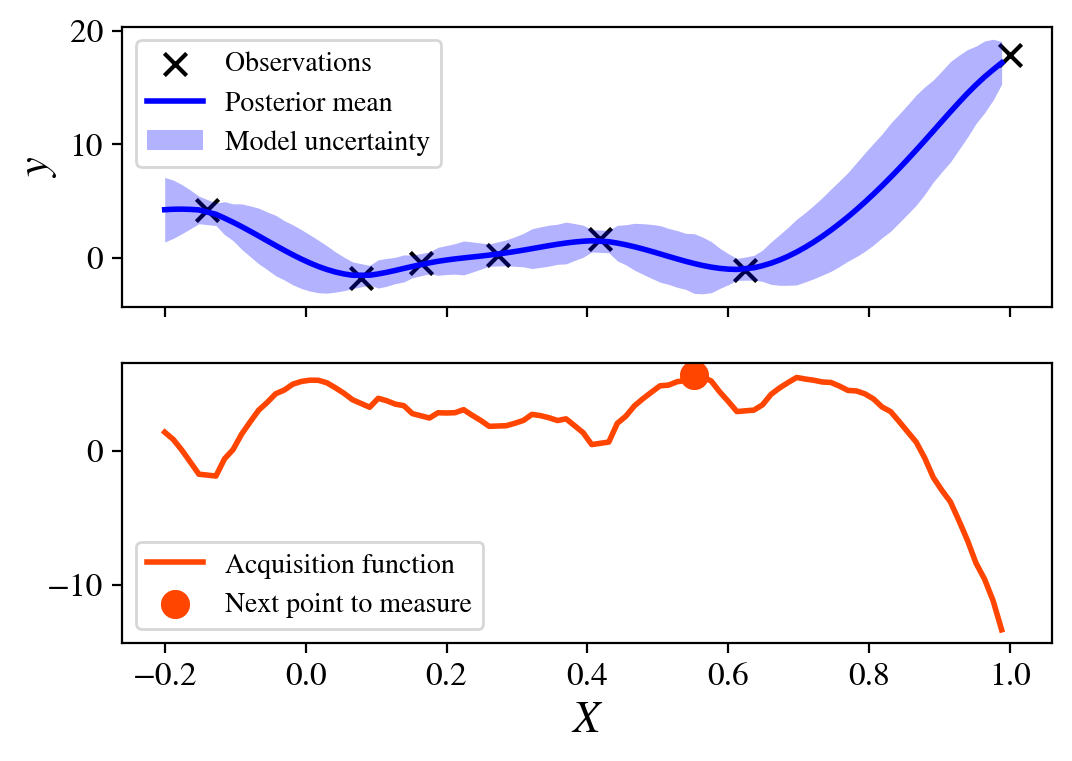


Step 7/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 147.10it/s, 7 steps of size 3.88e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.19      0.07      0.19      0.09      0.31    202.81      1.00
    k_scale     33.78     13.96     30.76     14.85     52.67    225.00      1.00
      noise      0.41      0.30      0.34      0.00      0.84    232.41      1.00



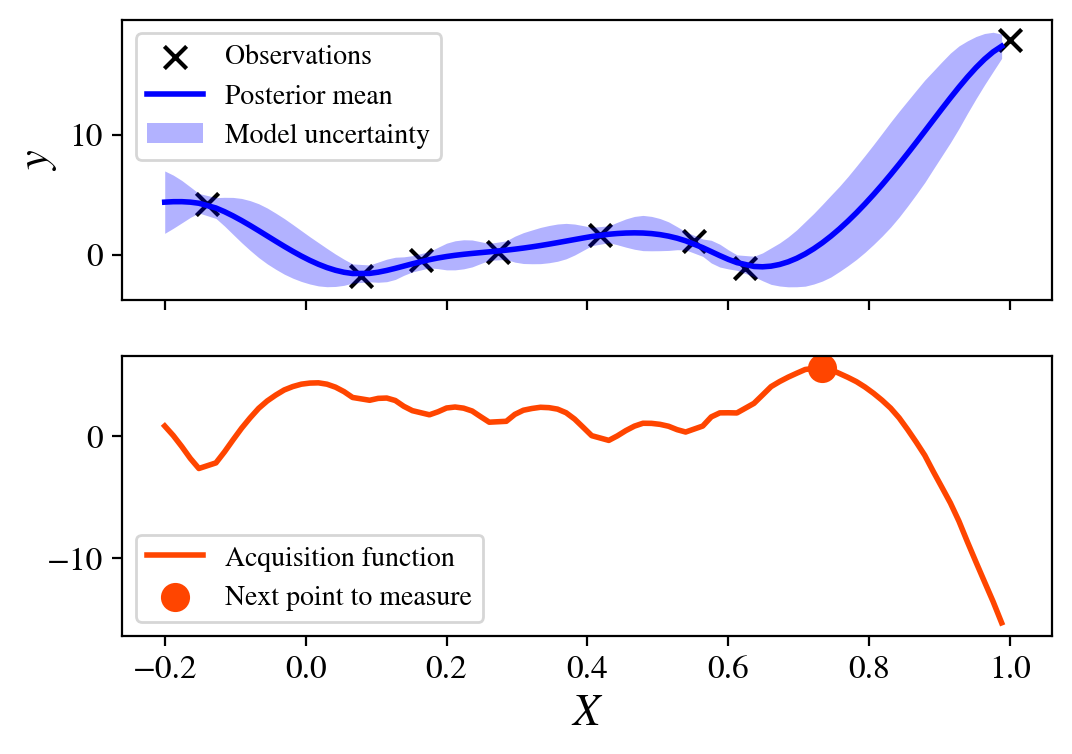


Step 8/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 146.13it/s, 7 steps of size 4.37e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.17      0.06      0.18      0.07      0.27    139.89      1.00
    k_scale     34.46     15.54     30.84     13.47     55.04    175.05      1.00
      noise      0.39      0.27      0.35      0.00      0.77    488.31      1.00



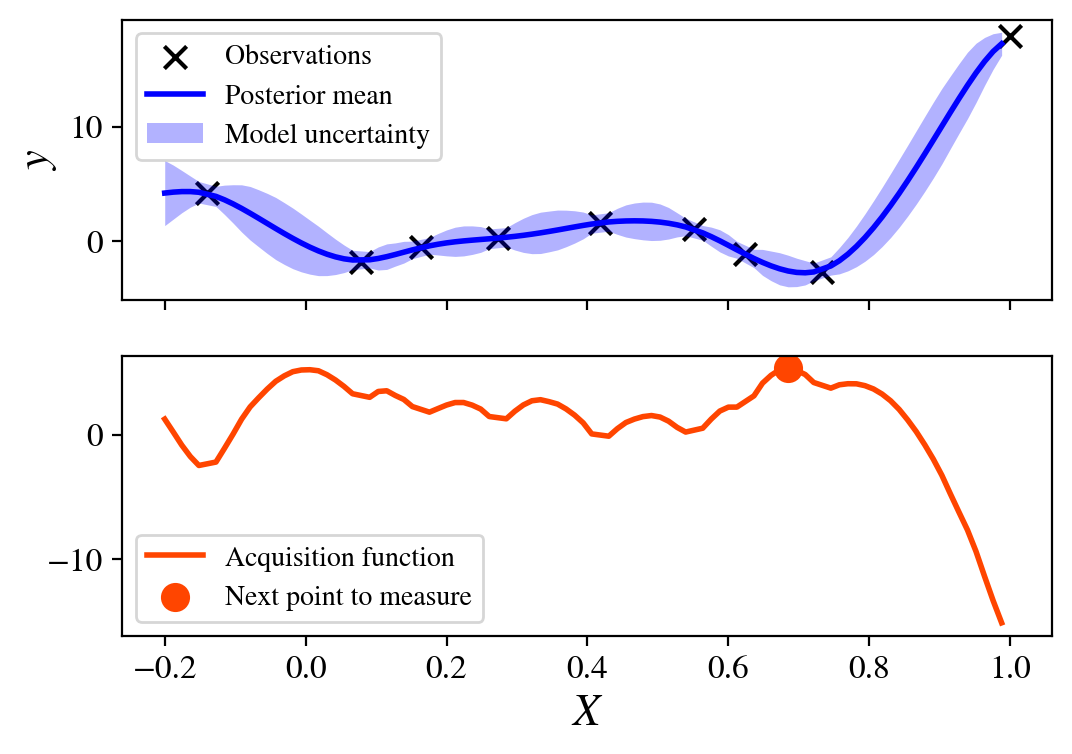


Step 9/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 155.36it/s, 3 steps of size 5.29e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.18      0.05      0.18      0.10      0.26    203.66      1.00
    k_scale     32.48     13.18     29.54     14.54     51.81    252.45      1.01
      noise      0.36      0.27      0.29      0.00      0.76    246.33      1.01



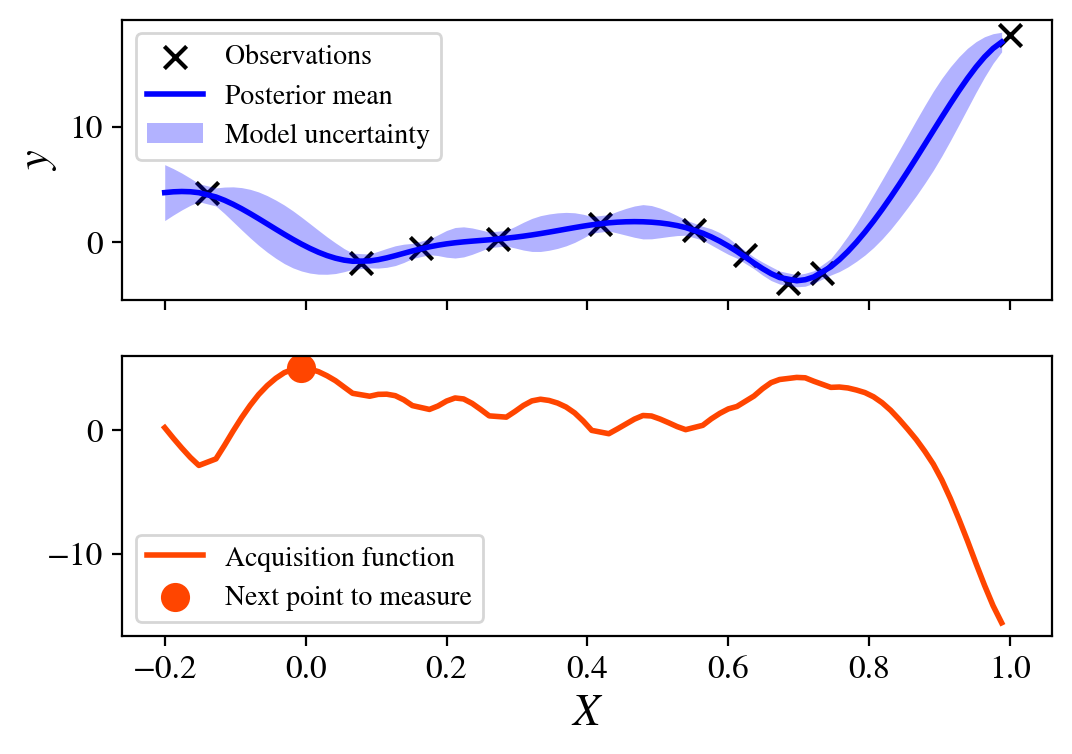


Step 10/10


sample: 100%|██████████| 1000/1000 [00:06<00:00, 150.30it/s, 7 steps of size 4.73e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.19      0.05      0.19      0.12      0.29    175.25      1.00
    k_scale     34.18     14.41     31.47     14.16     54.04    261.15      1.00
      noise      0.35      0.27      0.28      0.02      0.76    264.40      1.00



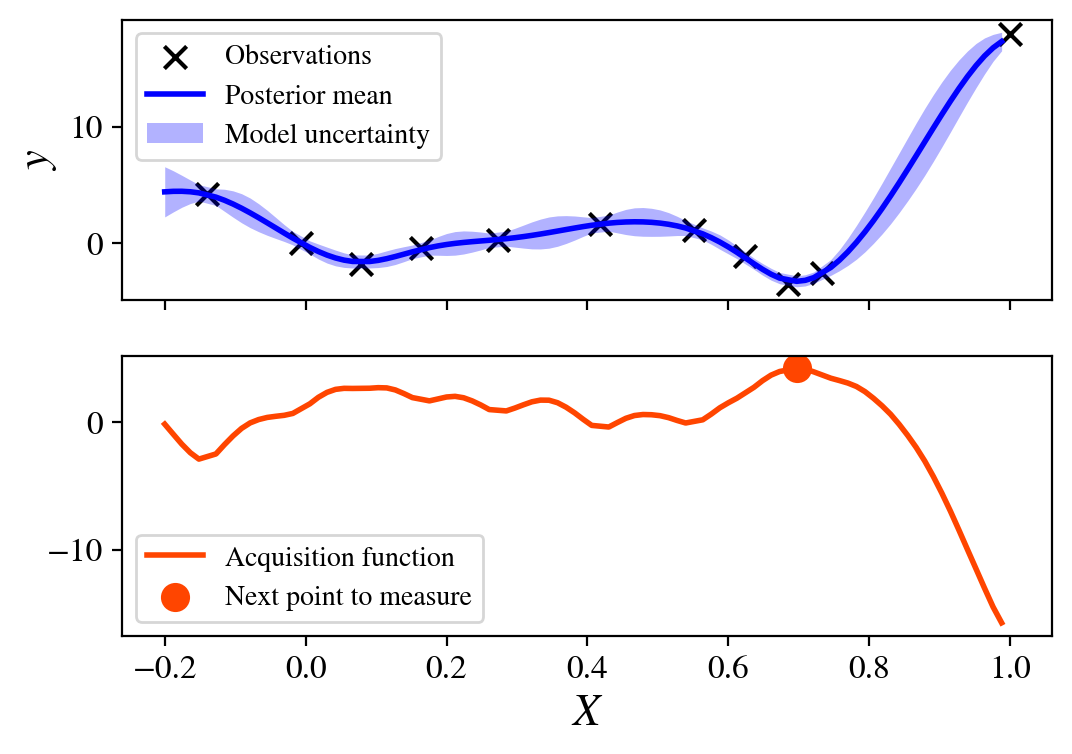

In [ ]:
num_steps = 10

np.random.seed(seed) # for reproducibility

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))

    # Initialize vanilla GP model
    gp_model = gpax.ExactGP(
        input_dim=1,
        kernel='Matern',
        noise_prior_dist=noise_prior,
        lengthscale_prior_dist=lenghtscale_prior,
    )

    # Single BO step computes acquisition function
    acq, (y_pred, y_sampled) = step(gp_model, X_measured, y_measured, X_unmeasured)

    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]

    # Measure the point
    next_point_value = y2_func(next_point, noise=obs_noise)

    # Update measured data
    X_measured = np.append(X_measured, X_unmeasured[idx:idx+1])
    y_measured = np.append(y_measured, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
    ax1.scatter(X_measured[:-1], y_measured[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='b', alpha=0.3, label="Model uncertainty", linewidth=0)
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.legend(loc='best', fontsize=10)
    ax1.set_ylabel("$y$", fontsize=16)
    ax2.set_xlabel("$X$", fontsize=16)
    plt.show()

    # Update array of unmeasured points ny removing coordinates of the point we just measured
    X_unmeasured = np.delete(X_unmeasured, idx)

Plot the results:

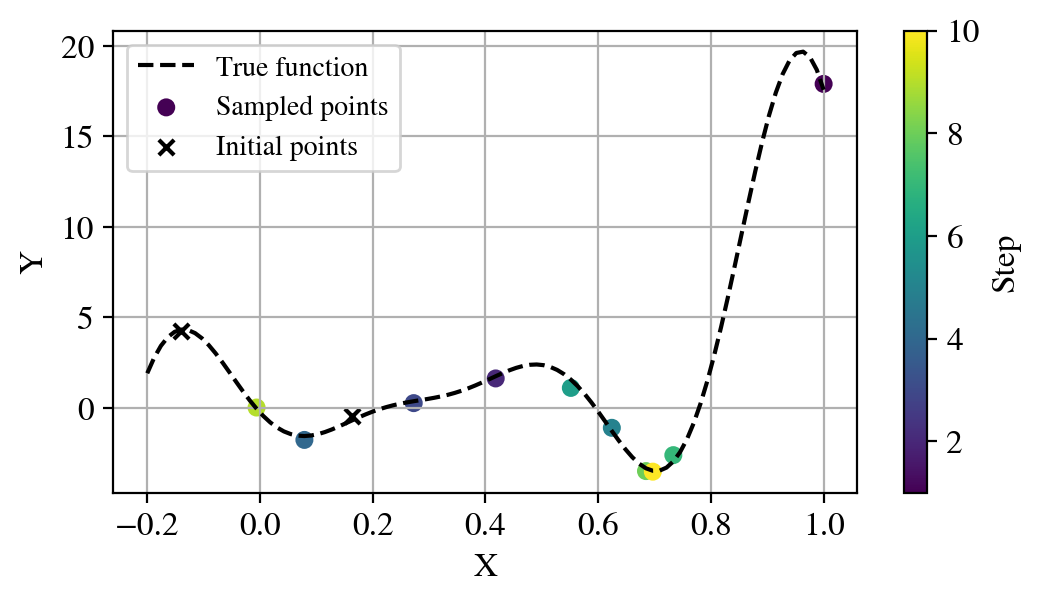

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(X_full_range, y2_true, 'k--', label='True function')
plt.scatter(X_measured[num_seed_points:], y_measured[num_seed_points:], s=30,
            c=np.arange(1, len(X_measured[num_seed_points:])+1), label='Sampled points')
plt.colorbar(label='Step')
plt.scatter(X_measured[:num_seed_points], y_measured[:num_seed_points], s=30,
            marker='x', label='Initial points', c='k')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

Now let's run the multi-task GP-BO. At the data preparation step, we need to add indices to each $X$ point that will inform the multi-task GP whether the corresponding target $y$ comes from theoretical simulations (index 0) and experimental observations (index 1). When running BO, we will be appending new measurements to ```X_measured_all``` and ```y_measured_all```.


In [ ]:
# Assign indices to simulation and experimental points and concatenate them together
X_measured_all = np.vstack(
    (np.column_stack((X_full_range.copy(), np.zeros_like(X_full_range))),  # "theory" data points
     np.column_stack((X2.copy(), np.ones_like(X2))))  # "experimental" data points
)

# Cocnatenate the corresponding targets
y_measured_all = np.concatenate([y1.copy(), y2.copy()]).squeeze()  # [theory, experiment]

# Array of unmeasured points
X_unmeasured = np.delete(X_full_range, X2_idx)

# We are interested in predicting only the values associated with the 2nd task
X_unmeasured2 = np.column_stack([X_unmeasured, np.ones_like(X_unmeasured)])

num_seed_points = len(X_measured_all[len(y1):])

print(X_measured_all.shape, y_measured_all.shape, X_unmeasured2.shape)

(102, 2) (102,) (98, 2)


Same as before, we define a custom noise prior. The noise prior for experimental data is the same as in the single output case (vanilla GP), but we also added a prior for a potential small noise in simulated data. We will be re-using the same prior over the kernel lengthscale since we work with the same data points and input space.

For multi-output GP, we can also specify a prior over the correlation matrix $W$ in the task kernel. Again, this step is optional, but it can help with convergence. Since we expect that there is at least some correlation between two outputs, we center a prior normal distribution over elements of the $W$ matrix at ones with a standard deviation of two. Feel free to adjust it, including assigning different values to the diagonal and off-diagonal elements.

In [ ]:
multitask_noise_prior = dist.HalfNormal(
    jnp.array([0.1, 0.5])) # (task 1, task 2)

W_prior_dist = dist.Normal(
    jnp.ones(shape=(2, 2, 2)),  # loc (num_latents, num_tasks, rank)
    2*jnp.ones(shape=(2, 2, 2)) # var (num_latents, num_tasks, rank)
)


Step 1/10


sample: 100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s, 31 steps of size 1.23e-01. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.30      2.00      1.47     -1.73      4.60    337.70      1.00
     W[0,0,1]      1.20      1.93      1.25     -1.61      4.47    299.72      1.00
     W[0,1,0]      1.13      1.71      1.14     -1.81      3.65    503.48      1.00
     W[0,1,1]      1.07      1.80      1.07     -1.77      3.83    649.89      1.00
     W[1,0,0]      1.16      1.96      1.26     -1.92      4.46    345.00      1.00
     W[1,0,1]      1.17      2.06      1.13     -2.08      4.43    360.50      1.00
     W[1,1,0]      1.05      1.70      0.97     -1.72      3.77    648.77      1.00
     W[1,1,1]      1.14      2.06      1.18     -2.30      4.29    478.13      1.00
k_length[0,0]      0.28      0.06      0.26      0.22      0.32    111.36      1.01
k_length[1,0]      0.29      0.10      0.27      0.21      0.35     37.78      1.02
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

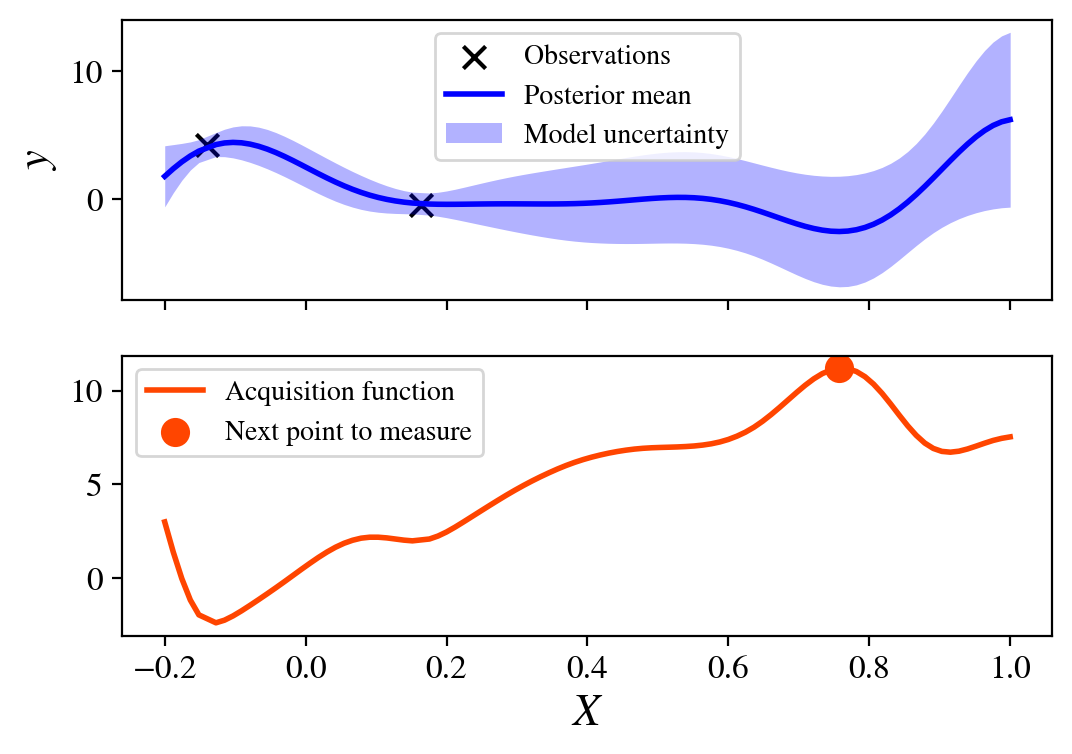


Step 2/10


sample: 100%|██████████| 1000/1000 [00:36<00:00, 27.05it/s, 31 steps of size 1.05e-01. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.27      2.00      1.28     -2.22      4.32    291.16      1.00
     W[0,0,1]      1.10      1.99      1.13     -1.70      4.52    193.22      1.00
     W[0,1,0]      0.95      1.53      0.97     -1.73      3.19    436.89      1.00
     W[0,1,1]      0.90      1.65      0.92     -1.72      3.45    321.97      1.00
     W[1,0,0]      1.18      1.96      1.17     -2.17      4.10    259.01      1.00
     W[1,0,1]      1.32      2.01      1.41     -1.92      4.49    297.78      1.00
     W[1,1,0]      1.00      1.61      0.98     -1.44      3.81    448.10      1.00
     W[1,1,1]      1.04      1.80      1.07     -2.09      3.74    451.10      1.00
k_length[0,0]      0.29      0.08      0.27      0.22      0.36     73.49      1.03
k_length[1,0]      0.29      0.09      0.27      0.22      0.36    176.40      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

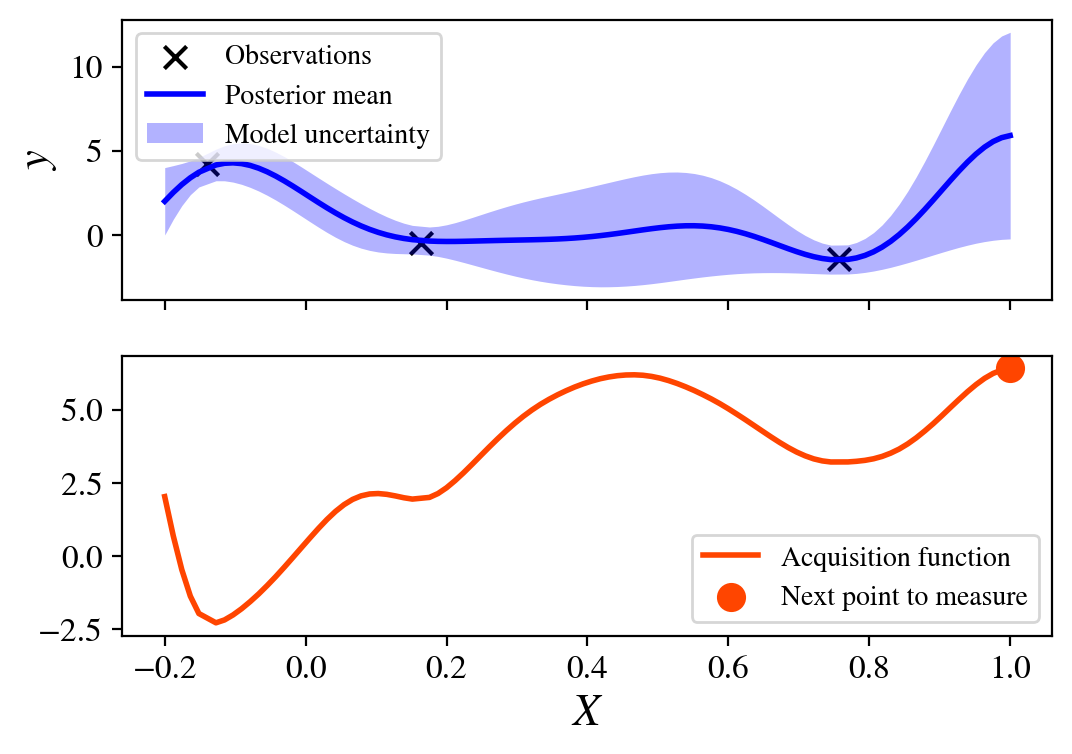


Step 3/10


sample: 100%|██████████| 1000/1000 [00:41<00:00, 24.36it/s, 31 steps of size 9.25e-02. acc. prob=0.96]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.66      1.86      1.94     -1.41      4.32    127.51      1.00
     W[0,0,1]      1.61      1.81      1.79     -1.06      4.65    152.50      1.00
     W[0,1,0]      1.89      2.01      2.12     -1.22      4.96    170.30      1.00
     W[0,1,1]      1.87      1.98      2.09     -1.23      4.87    164.03      1.00
     W[1,0,0]      1.17      1.72      1.10     -1.29      4.16    183.01      1.00
     W[1,0,1]      1.29      1.78      1.25     -1.28      4.14    176.83      1.00
     W[1,1,0]      1.53      1.93      1.52     -1.46      4.53    233.66      1.00
     W[1,1,1]      1.57      2.20      1.79     -2.04      4.97    272.36      1.00
k_length[0,0]      0.28      0.08      0.26      0.20      0.31    160.63      1.00
k_length[1,0]      0.31      0.12      0.27      0.20      0.43    114.40      1.01
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

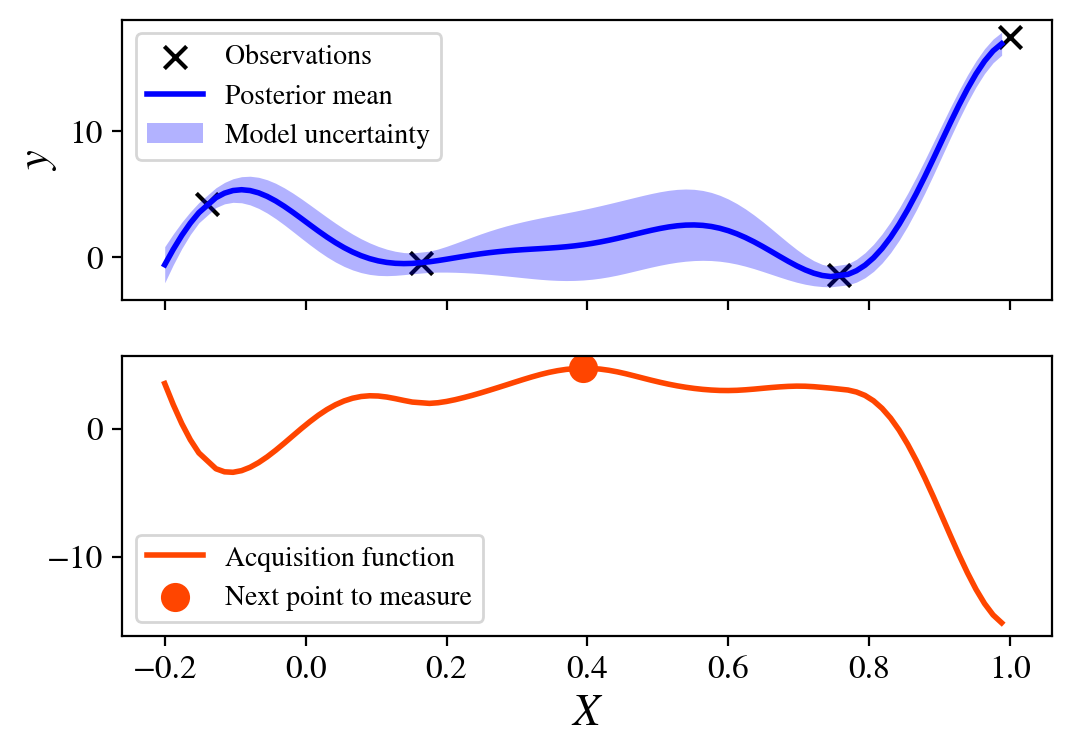


Step 4/10


sample: 100%|██████████| 1000/1000 [00:37<00:00, 26.66it/s, 31 steps of size 1.33e-01. acc. prob=0.92]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.51      1.77      1.47     -1.15      4.35    191.82      1.00
     W[0,0,1]      1.41      1.77      1.40     -1.23      4.44    143.02      1.00
     W[0,1,0]      1.70      1.92      1.88     -1.26      4.84    271.75      1.00
     W[0,1,1]      1.67      1.91      1.77     -1.77      4.35    311.11      1.00
     W[1,0,0]      1.47      1.72      1.51     -1.09      4.39    202.27      1.00
     W[1,0,1]      1.47      1.95      1.53     -1.56      4.22    186.82      1.00
     W[1,1,0]      1.59      1.84      1.70     -0.96      4.77    241.65      1.00
     W[1,1,1]      1.61      2.15      1.93     -1.75      5.16    230.18      1.00
k_length[0,0]      0.31      0.15      0.27      0.19      0.45    107.20      1.00
k_length[1,0]      0.30      0.12      0.27      0.22      0.42     97.71      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

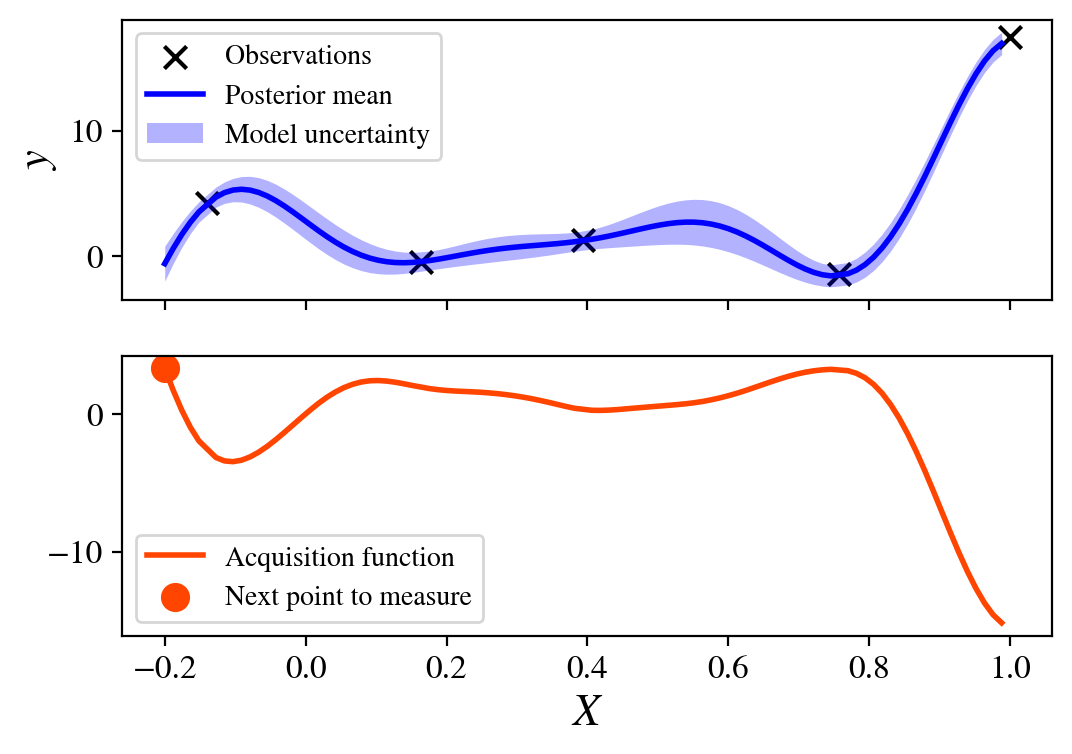


Step 5/10


sample: 100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s, 31 steps of size 1.04e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.69      1.91      1.93     -1.17      4.67     84.06      1.00
     W[0,0,1]      1.77      1.86      1.96     -0.99      4.46    134.12      1.02
     W[0,1,0]      1.77      1.86      1.92     -1.24      4.51    178.04      1.00
     W[0,1,1]      1.79      2.02      2.06     -1.57      4.73    200.90      1.01
     W[1,0,0]      1.17      1.62      1.09     -1.15      4.06    180.66      1.00
     W[1,0,1]      1.23      1.71      1.06     -1.46      3.93    139.20      1.00
     W[1,1,0]      1.48      1.84      1.52     -1.16      5.01    282.42      1.00
     W[1,1,1]      1.46      2.04      1.56     -1.77      4.78    403.48      1.00
k_length[0,0]      0.29      0.11      0.26      0.22      0.33    155.52      1.00
k_length[1,0]      0.33      0.15      0.27      0.22      0.52     40.85      1.09
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

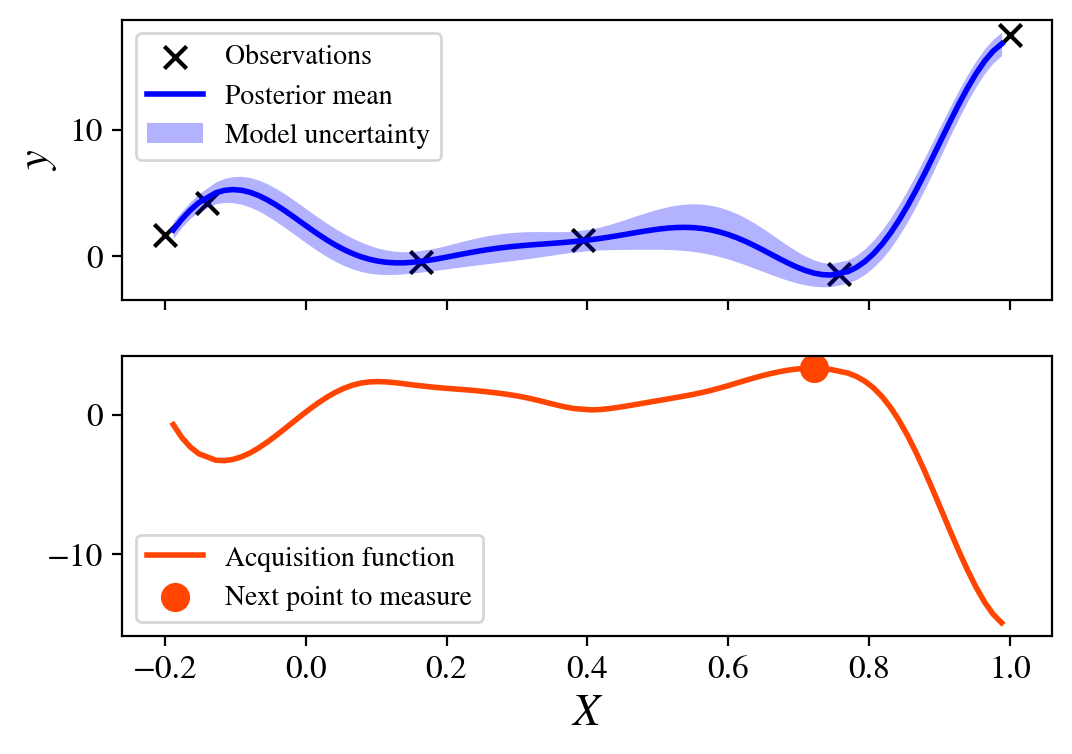


Step 6/10


sample: 100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s, 31 steps of size 1.46e-01. acc. prob=0.93]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.47      1.94      1.74     -1.56      4.44    155.80      1.00
     W[0,0,1]      1.46      1.83      1.53     -1.17      4.43    338.92      1.00
     W[0,1,0]      1.58      1.97      1.67     -1.34      5.01    183.09      1.00
     W[0,1,1]      1.70      2.00      1.88     -1.28      4.92    389.21      1.01
     W[1,0,0]      1.30      1.77      1.44     -1.06      4.25    194.99      1.00
     W[1,0,1]      1.24      1.84      1.35     -1.44      4.51    212.30      1.00
     W[1,1,0]      1.57      1.88      1.74     -1.59      4.26    233.37      1.00
     W[1,1,1]      1.40      2.15      1.51     -2.50      4.64    291.97      1.00
k_length[0,0]      0.28      0.08      0.26      0.21      0.33    216.02      1.00
k_length[1,0]      0.29      0.12      0.26      0.21      0.33     93.17      1.02
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

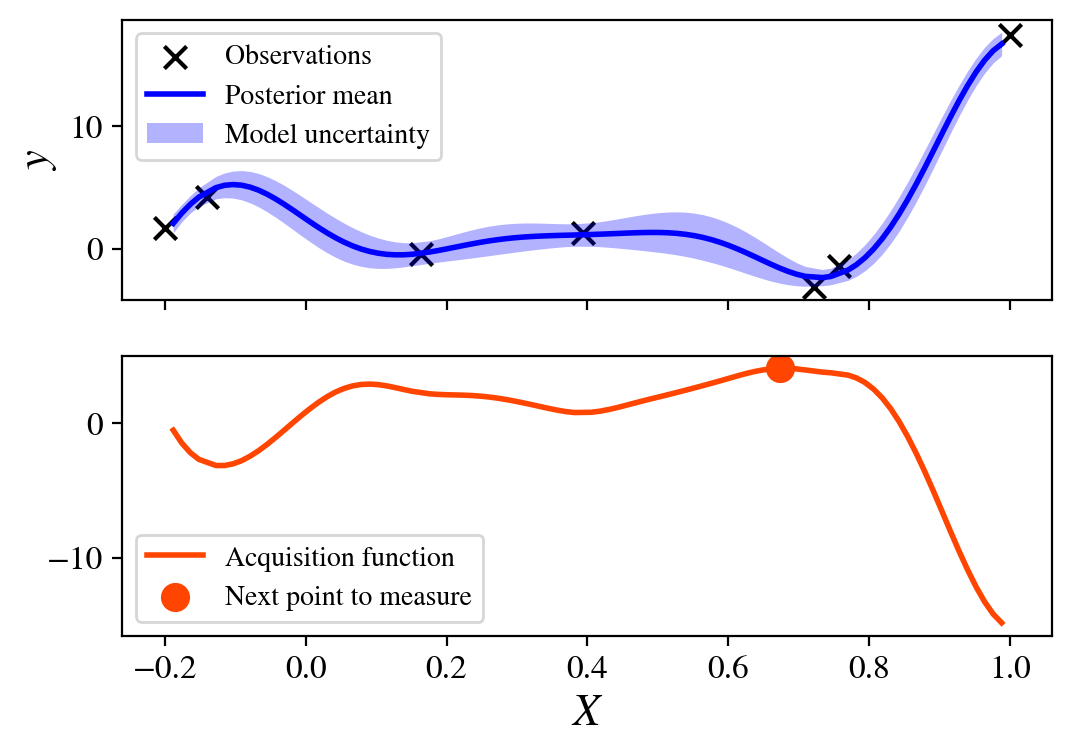


Step 7/10


sample: 100%|██████████| 1000/1000 [00:36<00:00, 27.04it/s, 31 steps of size 1.35e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.40      1.77      1.39     -1.35      4.41    169.94      1.00
     W[0,0,1]      1.30      1.71      1.16     -1.14      4.41    301.74      1.00
     W[0,1,0]      1.68      1.97      1.94     -1.41      4.66    440.14      1.00
     W[0,1,1]      1.60      2.03      1.81     -1.53      5.02    450.59      1.00
     W[1,0,0]      1.37      1.89      1.32     -1.41      4.43    251.53      1.01
     W[1,0,1]      1.51      1.86      1.44     -1.12      4.52    222.32      1.00
     W[1,1,0]      1.66      1.96      1.90     -1.10      5.01    245.60      1.01
     W[1,1,1]      1.52      2.18      1.85     -1.75      5.03    300.47      1.00
k_length[0,0]      0.29      0.10      0.26      0.20      0.35     85.82      1.01
k_length[1,0]      0.28      0.09      0.26      0.21      0.35     25.69      1.04
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

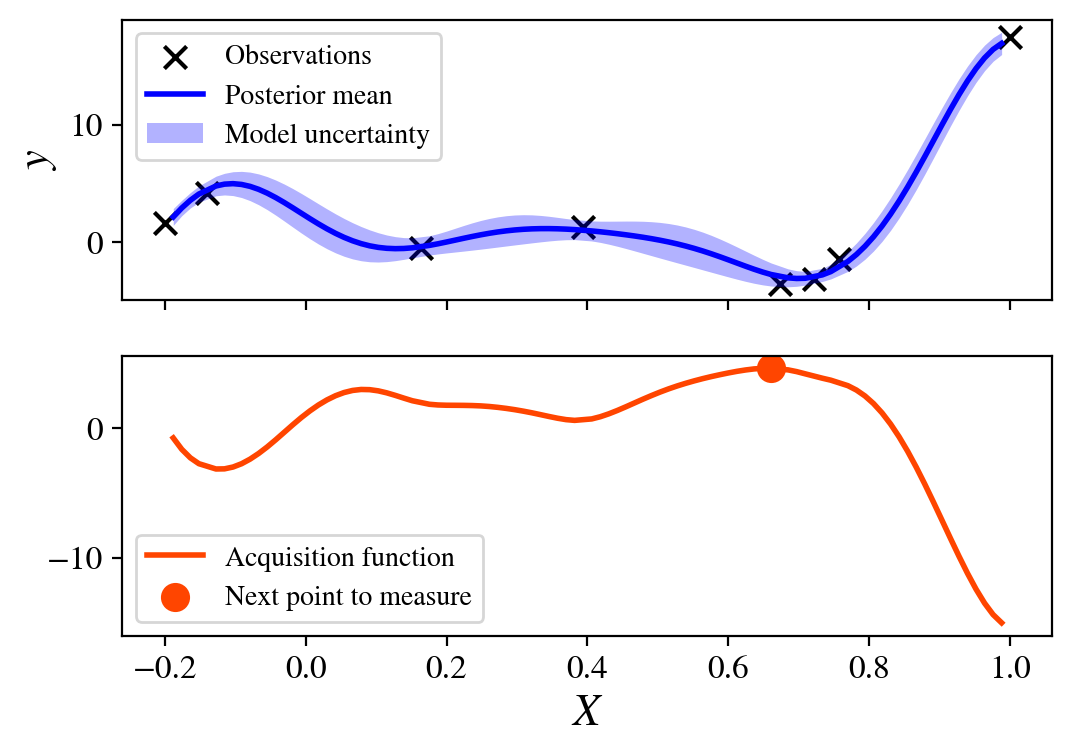


Step 8/10


sample: 100%|██████████| 1000/1000 [00:38<00:00, 25.87it/s, 31 steps of size 1.18e-01. acc. prob=0.96]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.48      1.85      1.61     -1.35      4.67    200.70      1.00
     W[0,0,1]      1.31      1.84      1.45     -1.70      4.24    209.13      1.00
     W[0,1,0]      1.66      2.02      1.90     -1.59      4.77    235.00      1.00
     W[0,1,1]      1.56      2.05      1.75     -1.53      4.78    254.90      1.00
     W[1,0,0]      1.35      1.74      1.54     -1.29      4.06    204.70      1.01
     W[1,0,1]      1.29      1.87      1.40     -1.28      4.66    188.81      1.00
     W[1,1,0]      1.65      1.99      1.79     -1.36      4.82    210.92      1.02
     W[1,1,1]      1.42      2.08      1.66     -1.84      4.76    239.84      1.00
k_length[0,0]      0.27      0.05      0.26      0.22      0.33    152.55      1.01
k_length[1,0]      0.27      0.04      0.26      0.21      0.34    158.84      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

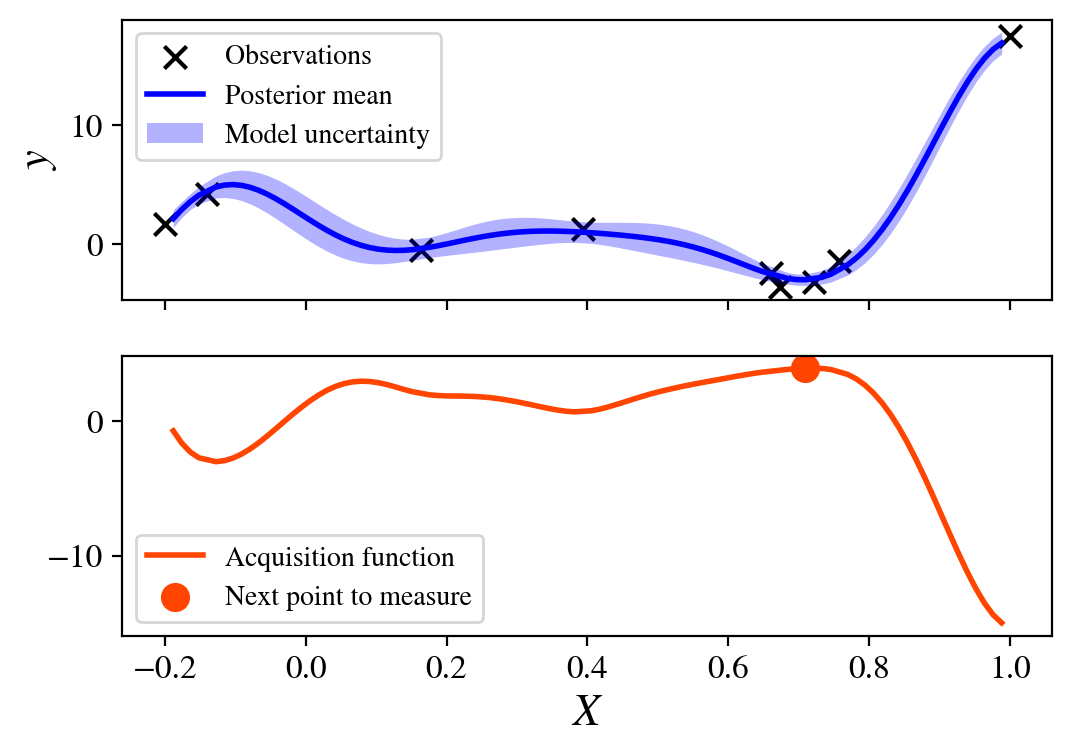


Step 9/10


sample: 100%|██████████| 1000/1000 [00:41<00:00, 24.26it/s, 31 steps of size 1.10e-01. acc. prob=0.96]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.63      1.93      1.79     -1.62      4.51    134.35      1.00
     W[0,0,1]      1.53      1.88      1.73     -1.26      4.48    139.21      1.00
     W[0,1,0]      1.83      1.91      2.09     -1.30      4.65    245.21      1.00
     W[0,1,1]      1.79      1.95      2.00     -1.46      4.63    254.92      1.00
     W[1,0,0]      1.17      1.67      1.13     -1.39      4.07    153.54      1.01
     W[1,0,1]      1.10      1.81      1.00     -1.72      4.01    175.56      1.00
     W[1,1,0]      1.55      1.93      1.64     -1.26      4.93    213.90      1.00
     W[1,1,1]      1.38      2.18      1.51     -1.88      4.85    319.04      1.00
k_length[0,0]      0.27      0.06      0.26      0.22      0.31    107.40      1.01
k_length[1,0]      0.33      0.18      0.27      0.18      0.55     31.66      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

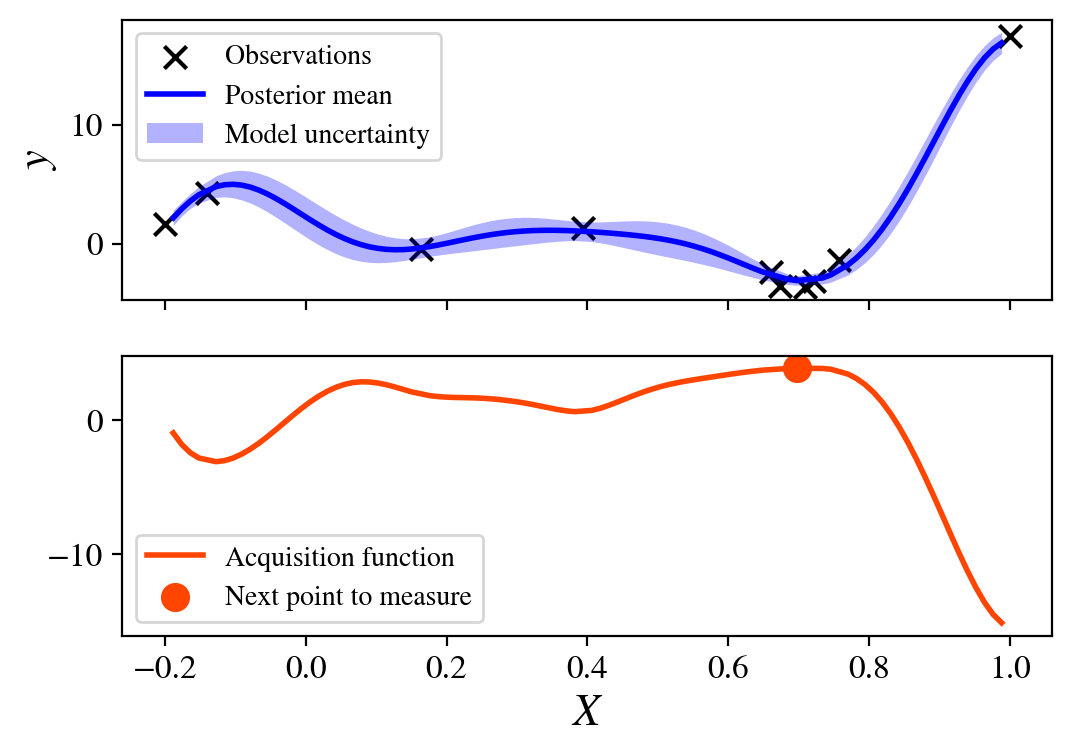


Step 10/10


sample: 100%|██████████| 1000/1000 [00:40<00:00, 24.41it/s, 31 steps of size 1.24e-01. acc. prob=0.95]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.42      1.82      1.52     -1.06      4.73    167.44      1.00
     W[0,0,1]      1.45      1.77      1.71     -1.20      4.22    258.03      1.00
     W[0,1,0]      1.58      2.00      1.81     -1.76      4.63    269.98      1.00
     W[0,1,1]      1.70      1.99      1.89     -1.66      4.76    409.43      1.00
     W[1,0,0]      1.16      1.78      1.10     -1.78      3.91    297.61      1.00
     W[1,0,1]      1.46      1.77      1.60     -1.40      4.16    271.51      1.00
     W[1,1,0]      1.49      1.94      1.54     -1.54      4.57    424.24      1.01
     W[1,1,1]      1.57      2.12      1.83     -2.76      4.35    408.89      1.00
k_length[0,0]      0.27      0.05      0.26      0.22      0.32    372.93      1.00
k_length[1,0]      0.27      0.06      0.26      0.21      0.34    126.83      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

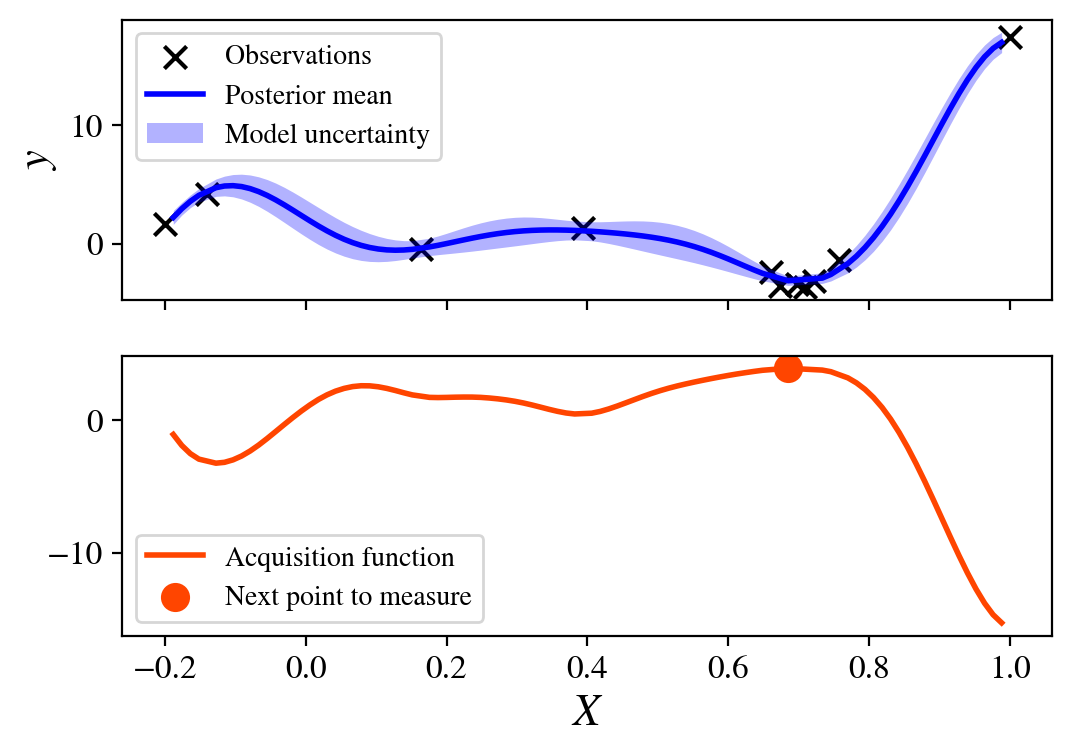

In [ ]:
num_steps = 10

np.random.seed(seed) # for reproducibility

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    gp_model = gpax.MultiTaskGP(
        input_dim=1,
        data_kernel='Matern',
        shared_input_space=False,
        num_latents=2,
        rank=2,
        noise_prior_dist=multitask_noise_prior,
        lengthscale_prior_dist=lenghtscale_prior,
        W_prior_dist=W_prior_dist
    )

    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(
        gp_model,
        X_measured_all,
        y_measured_all,
        X_unmeasured2
    )

    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured2[idx:idx+1, 0]

    # Measure the point
    next_point_value = y2_func(next_point, noise=obs_noise)

    # Update measured data
    X_measured_all = np.append(X_measured_all, X_unmeasured2[idx:idx+1], axis=0)
    y_measured_all = np.append(y_measured_all, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
    ax1.scatter(X_measured_all[len(y1):-1, 0], y_measured_all[len(y1):-1], marker='x', c='k', label="Observations", s=64)
    ax1.plot(X_unmeasured2[:,0], y_pred, lw=2, c='b', label='Posterior mean')
    ax1.fill_between(X_unmeasured2[:,0], lower_b, upper_b, color='b', alpha=0.3, label="Model uncertainty", linewidth=0)
    ax2.plot(X_unmeasured2[:,0], acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured2[idx][0], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.legend(loc='best', fontsize=10)
    ax1.set_ylabel("$y$", fontsize=16)
    ax2.set_xlabel("$X$", fontsize=16)
    plt.show()

    # Update the array of unmeasured point by removing the point that we have just measured
    X_unmeasured2 = np.delete(X_unmeasured2, idx, axis=0)

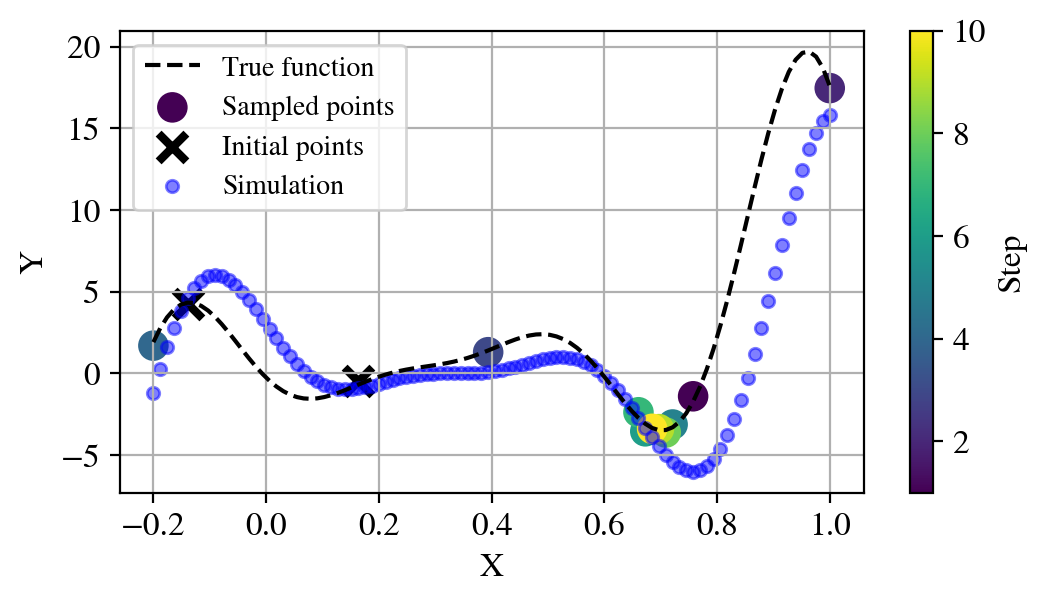

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(X_full_range, y2_true, 'k--', label='True function')
plt.scatter(X_measured_all[(len(y1)+num_seed_points):, 0],  y_measured_all[(len(y1)+num_seed_points):],
            s=100, c=np.arange(1, len(X_measured_all[(len(y1)+num_seed_points):, 0])+1), label='Sampled points')
plt.colorbar(label='Step')
plt.scatter(X_measured_all[len(y1):len(y1)+num_seed_points, 0],  y_measured_all[len(y1):len(y1)+num_seed_points],
            s=100, marker='x', label='Initial points', c='k', lw=3)
plt.scatter(X_full_range, y1, c='b', alpha=0.5, s=20, label='Simulation')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

The "theory-informed" GP-BO has clearly outperformed vanilla BO on this case. Note that the selection of the initial ("seed") points was somewhat unfavorable to a purely data-driven optimization method. We did this intentionally to highlight how a multi-output GP successfully avoids local minima due to the information it garners from theoretical models or simulations. We posit that this methodology could prove advantageous for researchers aiming to explore or optimize certain physical properties, especially in higher-dimensional or more complex parameter spaces.

Let's also get a prediciton over the full range and plot it:

In [ ]:
gp_model = gpax.MultiTaskGP(
    input_dim=1,
    data_kernel='Matern',
    shared_input_space=False,
    num_latents=2,
    rank=2,
    noise_prior_dist=multitask_noise_prior,
    lengthscale_prior_dist=lenghtscale_prior,
    W_prior_dist=W_prior_dist
)

# Compute acquisition function
_, (y_pred, y_sampled) = step(
    gp_model,
    X_measured_all,
    y_measured_all,
    np.column_stack([X_full_range, np.ones_like(X_full_range)])
)

sample: 100%|██████████| 1000/1000 [00:34<00:00, 28.71it/s, 31 steps of size 1.39e-01. acc. prob=0.94]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     W[0,0,0]      1.49      1.76      1.77     -1.09      4.49    242.30      1.00
     W[0,0,1]      1.34      1.78      1.55     -1.22      4.29    340.79      1.00
     W[0,1,0]      1.66      2.07      1.89     -1.61      4.73    362.86      1.00
     W[0,1,1]      1.73      1.90      1.98     -1.74      4.26    344.75      1.00
     W[1,0,0]      1.31      1.73      1.37     -1.34      4.16    234.19      1.00
     W[1,0,1]      1.25      1.86      1.24     -1.53      4.22    259.51      1.00
     W[1,1,0]      1.63      1.85      1.87     -0.76      5.26    540.16      1.00
     W[1,1,1]      1.49      2.17      1.72     -1.87      5.01    346.02      1.00
k_length[0,0]      0.26      0.03      0.26      0.22      0.30    347.87      1.00
k_length[1,0]      0.28      0.09      0.26      0.21      0.33    183.01      1.00
   k_scale[0]      1.00      0.00      1.00      1.00      1.00       nan  

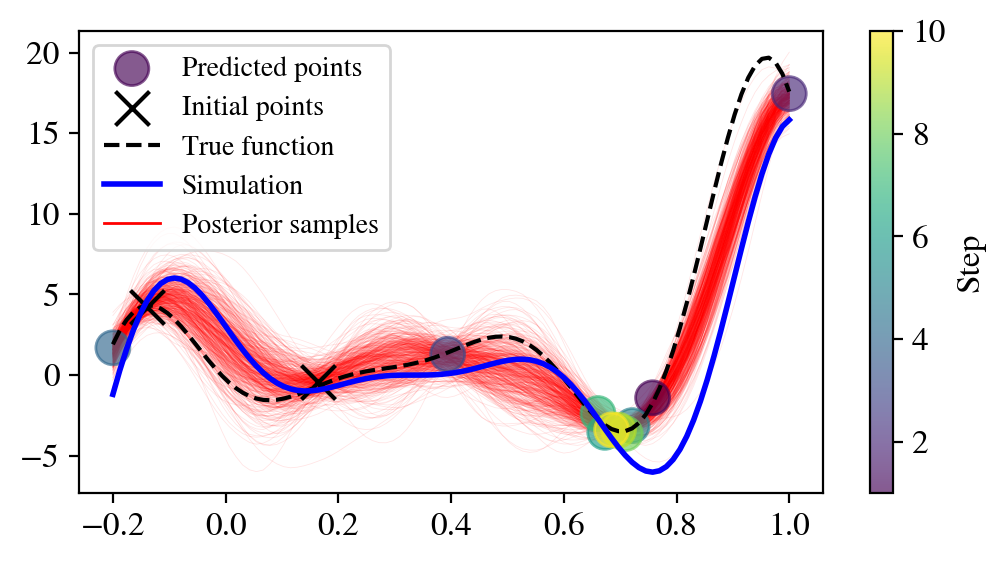

In [ ]:
_, ax = plt.subplots(figsize=(6, 3))
cax = ax.scatter(X_measured_all[(len(y1)+num_seed_points):, 0],  y_measured_all[(len(y1)+num_seed_points):],
            s=150, c=np.arange(1, len(X_measured_all[(len(y1)+num_seed_points):, 0])+1), label='Predicted points', alpha=0.65)
cbar = fig.colorbar(cax)
cbar.set_label("Step")
ax.scatter(X_measured_all[len(y1):len(y1)+num_seed_points, 0],  y_measured_all[len(y1):len(y1)+num_seed_points],
            s=150, marker='x', label='Initial points', c='k')
ax.plot(X_full_range, y2_true, 'k--', label='True function')
ax.plot(X_full_range, y1, 'b', lw=2, label='Simulation')
ax.legend()
for yi in y_sampled:
    ax.plot(X_full_range, yi.mean(0), lw=.3, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_full_range, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Posterior samples")
ax.legend(loc='upper left')
l.set_alpha(0)
plt.show()